# Modelo RNN-LSTM

![tittle](Images/lstm.png)

In [1]:
from tensorflow import keras as kr
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
tickerSymbol = '^GSPC'
tickerData = yf.Ticker(tickerSymbol)
sp500_close = tickerData.history(period='1mo', start='2005-04-1', end='2020-04-05')
sp500_close

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2005-04-01,1180.59,1189.80,1169.91,1172.92,2168690000,0,0
2005-04-04,1172.79,1178.61,1167.72,1176.12,2079770000,0,0
2005-04-05,1176.12,1183.56,1176.12,1181.39,1870800000,0,0
2005-04-06,1181.39,1189.34,1181.39,1184.07,1797400000,0,0
2005-04-07,1184.07,1191.88,1183.81,1191.14,1900620000,0,0
...,...,...,...,...,...,...,...
2020-03-30,2558.98,2631.80,2545.28,2626.65,5746220000,0,0
2020-03-31,2614.69,2641.39,2571.15,2584.59,6568290000,0,0
2020-04-01,2498.08,2522.75,2447.49,2470.50,5947900000,0,0


Text(0, 0.5, 'precio')

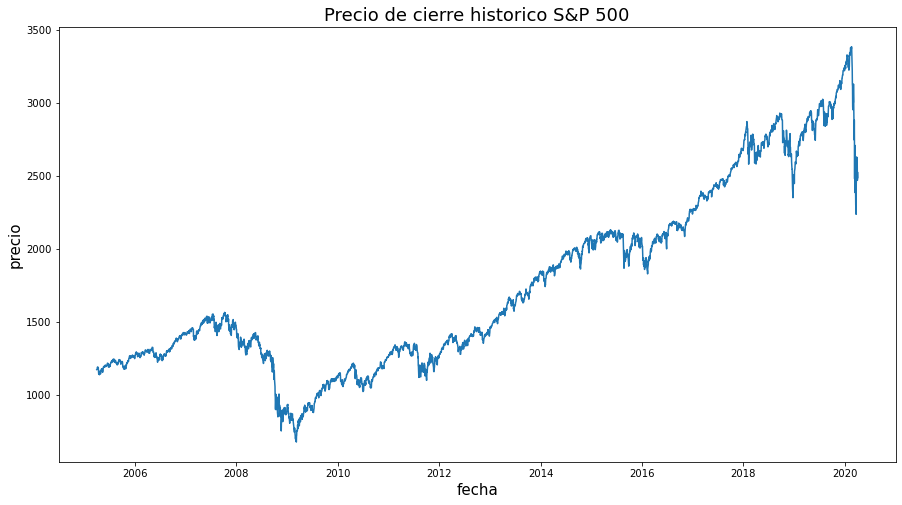

In [4]:
plt.figure(figsize=(15,8))
plt.title('Precio de cierre historico S&P 500',fontsize = 18)
plt.plot(sp500_close['Close'])
plt.xlabel('fecha',fontsize = 15)
plt.ylabel('precio',fontsize = 15)

Filtrar 'Close' y convertir a numpy

In [5]:
sp500_close = sp500_close.filter(['Close'])

In [6]:
sp500_np = sp500_close.values
type(sp500_np)

numpy.ndarray

In [7]:
longitud_entrenamiento = int(len(sp500_np)*.8)
longitud_entrenamiento

3023

Normalizado

In [8]:
escalado = MinMaxScaler(feature_range=(0,1))
sp500_norm = escalado.fit_transform(sp500_np)

Crear el dataset de entrenamiento

In [9]:
train_data = sp500_norm[0:longitud_entrenamiento,:]

dividir en x_train y y_train (2 ejecuciones)

In [10]:
x_train = []
y_train = []

for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0]) 
    y_train.append(train_data[i,0])      

convertir a numpy y agregar una dimension

In [11]:
x_train,y_train = np.array(x_train),np.array(y_train)

In [12]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(2963, 60, 1)

#### Crear LSTM model

In [13]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [14]:
model = Sequential()
model.add(LSTM(50, return_sequences= True, input_shape = (x_train.shape[1],1)))
model.add(LSTM(50, return_sequences= False,))
model.add(Dense(25))
model.add(Dense(1))

optimizar

In [15]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

entrenar modelo

In [16]:
model.fit(x_train,y_train,batch_size = 1, epochs = 1)

Train on 2963 samples
2963/2963 [==============================] - 76s 26ms/sample - loss: 4.5750e-04


Crear el dataset de prueba

In [17]:
test_data = sp500_norm[longitud_entrenamiento - 60:,:]

dividir en x_test y y_test

In [18]:
x_test = []
y_test = sp500_np[longitud_entrenamiento:,:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [19]:
x_test = np.array(x_test)

Agregar una dimension

In [20]:
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
x_test.shape

(756, 60, 1)

Predicciones

In [21]:
predic = model.predict(x_test)
predic = escalado.inverse_transform(predic) #quita el normalizado (dejara info similar a y_test)

confianza del modelo

Raíz de la Desviación Cuadrática Media (RMSE)

In [22]:
rmse = np.sqrt( np.mean(predic - y_test)**2)
rmse

100.57271701388889

Graficas

In [23]:
entrenamiento = sp500_close[:longitud_entrenamiento]
validacion = sp500_close[longitud_entrenamiento:]
validacion['Predicciones']= predic

C:\Users\af673\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


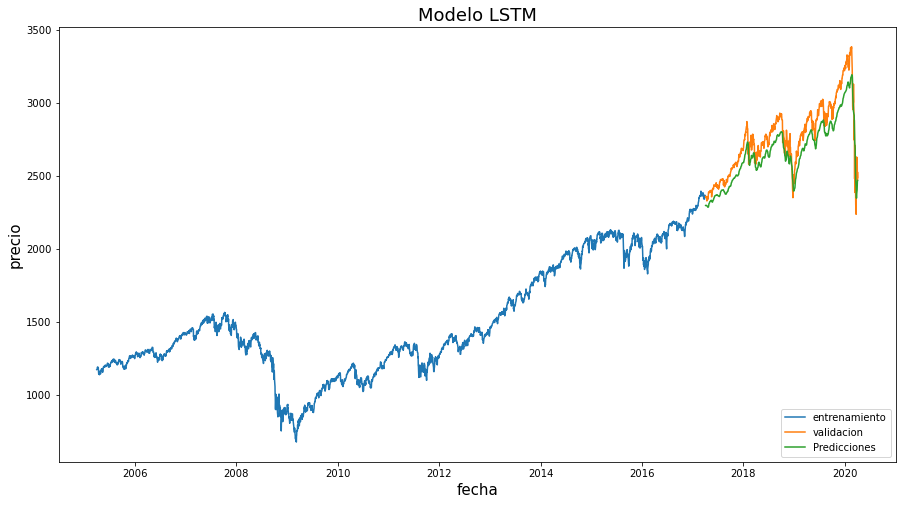

In [24]:
plt.figure(figsize=(15,8))
plt.title('Modelo LSTM',fontsize = 18)
plt.xlabel('fecha',fontsize = 15)
plt.ylabel('precio',fontsize = 15)
plt.plot(entrenamiento['Close'])
plt.plot(validacion[['Close','Predicciones']])
plt.legend(['entrenamiento','validacion','Predicciones'],loc = 'lower right')
plt.show()

In [25]:
validacion

,Close,Predicciones
Date,,
2017-04-04,2360.16,2298.364746
2017-04-05,2352.95,2299.252686
2017-04-06,2357.49,2298.928223
2017-04-07,2355.54,2298.656738
2017-04-10,2357.16,2298.156494
...,...,...
2020-03-30,2626.65,2403.441162
2020-03-31,2584.59,2436.622559
2020-04-01,2470.50,2462.497559


# Aplicacion en FAANG (MAYO)

In [113]:
def acciones_forecast(simbolo,fecha):
    x_prueba = []
    tickerSymbol = simbolo
    tickerData = yf.Ticker(tickerSymbol)
    nombre = tickerData.history(period='1mo', start='2005-04-1', end= fecha)
    nombre = nombre.filter(['Close'])
    last_days = nombre[-60:].values
    last_days_norm = escalado.fit_transform(last_days)
    x_prueba.append(last_days_norm)
    x_prueba = np.array(x_prueba)
    x_prueba = np.reshape(x_prueba,(x_prueba.shape[0],x_prueba.shape[1],1))
    norm_pred_price = model.predict(x_prueba)
    pred_price = escalado.inverse_transform(norm_pred_price)
    return pred_price[0][0]

In [114]:
acciones_forecast('AAPL','2020-04-28')

275.46948

In [88]:
Fechas = pd.date_range('2020-05-01', '2020-05-14', freq='B')
Fechas

DatetimeIndex(['2020-05-01', '2020-05-04', '2020-05-05', '2020-05-06',
               '2020-05-07', '2020-05-08', '2020-05-11', '2020-05-12',
               '2020-05-13', '2020-05-14'],
              dtype='datetime64[ns]', freq='B')

In [190]:
def tabla_predicciones(simbolo,fecha_inicial,fecha_final):
    fechas2 = []
    predict = []
    real = []
    fechas = pd.date_range(fecha_inicial, fecha_final, freq='B')
    for i in range(fechas.shape[0]):
        fechas2.append(str(fechas[i])[0:10])
    for i in range(len(fechas2)):
        predict.append(acciones_forecast(simbolo,fechas2[i]))
    tickerData = yf.Ticker(simbolo)
    nombre = tickerData.history(period='1mo', start=fecha_inicial, end= fecha_final)['Close']
    for i in range(len(nombre)):
        real.append(nombre[i])
    real.append('N/A')
    dict = {'Fechas':fechas2,'Prediccciones':predict,'Precio real':real}
    return pd.DataFrame(dict)
        

In [191]:
tabla_predicciones('AAPL','2020-05-01', '2020-05-14')

,Fechas,Prediccciones,Precio real
0,2020-05-01,279.407898,288.29
1,2020-05-04,281.247711,292.37
2,2020-05-05,283.186432,296.76
3,2020-05-06,285.434723,299.82
4,2020-05-07,287.888947,302.92
5,2020-05-08,NaN,310.13
6,2020-05-11,293.608093,315.01
7,2020-05-12,297.200836,311.41
8,2020-05-13,299.957306,307.65
9,2020-05-14,301.588776,N/A


In [192]:
tabla_predicciones('NFLX','2020-05-01', '2020-05-14')

,Fechas,Prediccciones,Precio real
0,2020-05-01,410.817444,415.27
1,2020-05-04,409.903625,428.15
2,2020-05-05,410.901154,424.68
3,2020-05-06,412.122986,434.26
4,2020-05-07,414.551880,436.53
5,2020-05-08,417.411102,435.55
6,2020-05-11,419.954224,440.52
7,2020-05-12,422.735107,431.82
8,2020-05-13,423.985443,438.27
9,2020-05-14,425.301697,N/A
